In [1]:
from sklearn.metrics import adjusted_rand_score as ari
import time
import numpy as np
import random
from copy import deepcopy
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS, MeanShift
from matplotlib import pyplot as plt

In [2]:
def generate_data(num_clusters, pops, d, n, flip_prob=0.1, seed=None):
    """
    Generate data for the CLASSIX_T dataset

        Parameters: \n
        num_clusters (int)  : number of clusters \n
        pops (list)         : the popcount of the different cluster centers. len(pops) must be equal to num_clusters \n
        d (int)             : dimension of the data \n
        n (int)             : number of total samples per cluster \n
        seed (int)          : seed for the random number generator \n
    """
    if len(pops) != num_clusters:
        try:
            print("The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user")
            pops = np.linspace(min(pops), max(pops), num_clusters)
        except:
            raise ValueError("The number of cluster centers must be equal to the number of cluster populations")
    
    size_flag = [pops[x]<d for x in range(len(pops))]
    
    assert all(size_flag), "The number of dimensions must be greater than the pop counts of the clusters"
    
    clustc = []
    data = []
    if seed != None:
        np.random.seed(seed)
        random.seed(seed)

    labels = []

    for i in range(num_clusters):
        pop = pops[i]
        p1 = pop/d
        clustc.append(np.random.choice([0, 1], size=d, p=[1-p1, p1]))
        labels.append(i)
        for j in range(n):
            labels.append(i)
            flip_indices = np.random.choice([0, 1], size = d, p = [1-flip_prob, flip_prob])
            new_sample = np.logical_xor(clustc[-1], flip_indices).astype(np.int32)
            data.append(new_sample)
            
    return np.array(data).astype(np.int32), np.array(labels).astype(np.int32), clustc

In [3]:
data, labels, clustc = generate_data(1, [40], 1000, 10, 0.01)

In [ ]:
def P2_P1(data, clustc, similarity, flip_prob=0.1, seed=None):
    """
    Given a dataset with n samples generated by using a given seed and a flip probability,
    this function estimates the efficiency of the search termination criterion of CLASSIX_T for different values of
    flip probability.
    """
    scores = np.sum(data, axis=1)
    sort_inds = np.argsort(scores)
    sorted_scores = scores[sort_inds]
    n = len(sorted_scores)
    sorted_data = data[sort_inds]
    query_score = np.sum(clustc[0])
    query_data = clustc[0]

    last_j = np.searchsorted(sorted_scores, query_score/similarity, side='right')
    first_j = np.searchsorted(sorted_scores, query_score*similarity, side='left')
    P1 = (last_j - first_j)/(n - 1)
    
    if P1 <= 0:
        return 0

    ips = sorted_data[first_j:last_j,:]@query_data
    vec = ips/(sorted_scores[first_j:last_j]+query_score)
    rhs = 1/similarity + 1
    rhsi = 1/rhs

    vec_mask = vec >= rhsi
    P2 = np.sum(vec_mask)/(n - 1)

    return P2/P1

all_information = []
def PLOTINFO(information, range_flip, pop_count):
    plt.plot(range_flip, information[:, 0], label="sim = 0.5", color="red")
    plt.plot(range_flip, information[:, 1], label="sim = 0.55", color="blue")
    plt.plot(range_flip, information[:, 2], label="sim = 0.6", color="green")
    plt.plot(range_flip, information[:, 3], label="sim = 0.65", color="orange")
    plt.plot(range_flip, information[:, 4], label="sim = 0.7", color="purple")
    plt.plot(range_flip, information[:, 5], label="sim = 0.75", color="pink")
    plt.plot(range_flip, information[:, 6], label="sim = 0.8", color="brown")
    plt.scatter(range_flip, information[:, 0], color="red")
    plt.scatter(range_flip, information[:, 1], color="blue")
    plt.scatter(range_flip, information[:, 2], color="green")
    plt.scatter(range_flip, information[:, 3], color="orange")
    plt.scatter(range_flip, information[:, 4], color="purple")
    plt.scatter(range_flip, information[:, 5], color="pink")
    plt.scatter(range_flip, information[:, 6], color="brown")
    # plt.title("Efficiency of the search termination criterion of CLASSIX_T")
    plt.xlabel("Flip Probability")
    plt.ylabel("Efficiency")
    plt.legend()
    # plt.savefig(f"plots/\u0251\u1d62={pop_count}.pdf", format="pdf", dpi=600)
    plt.show()
    all_information.append(information)

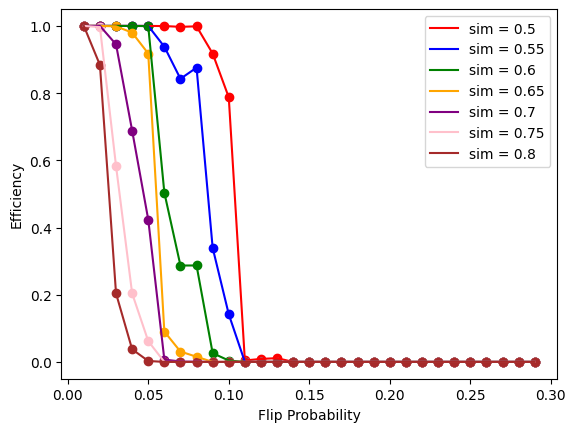

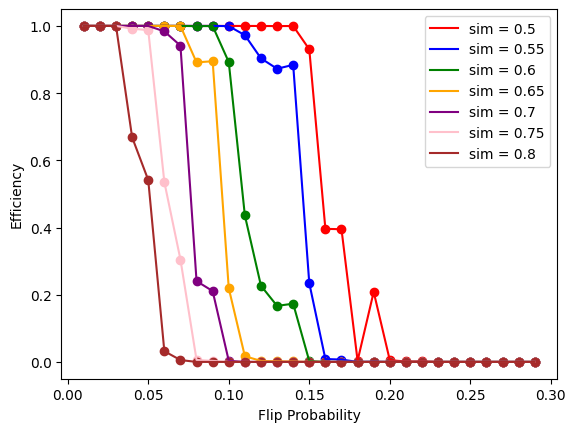

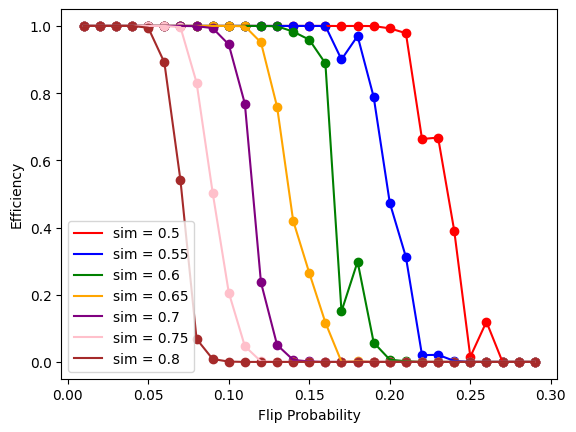

In [6]:

range_flip = np.arange(0.01, 0.3, 0.01)
range_sim = np.arange(0.5, 0.8, 0.05)
all_information = []
for k in range(100, 350, 100):
    information = np.zeros((len(range_flip), len(range_sim)))
    for i, flip_prob in enumerate(range_flip):
        data, labels, clustc = generate_data(1, [k], 1000, 10000, flip_prob)
        for j, similarity in enumerate(range_sim):

            efficiency = P2_P1(data, clustc, similarity, flip_prob)
            information[i, j] = efficiency
    
    PLOTINFO(information, range_flip, k)

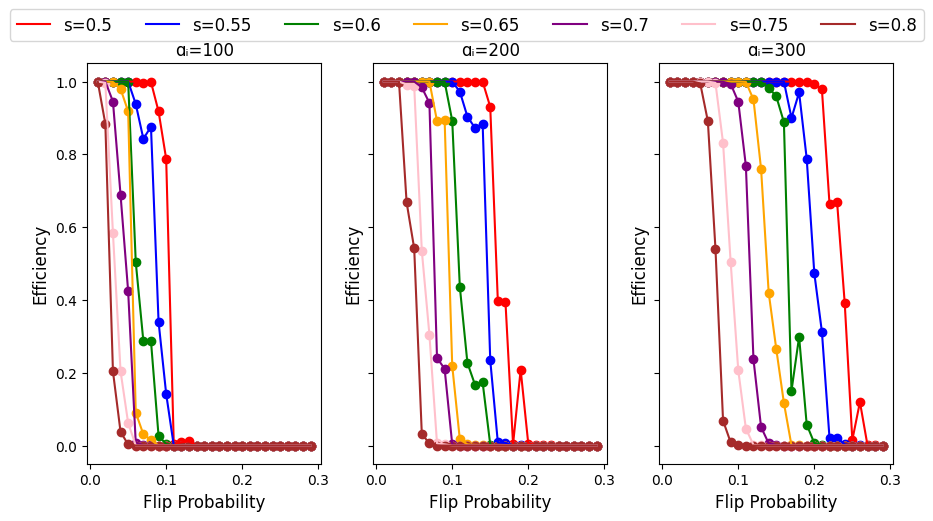

In [ ]:
num_plots = len(all_information)
cols = 3  #Higher settings lead to very small plots
rows = int(np.ceil(num_plots / cols))

# fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharey=True)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 5), sharey=True)
plt.title("Efficiency of the search termination criterion of CLASSIX_T for different query pop-counts. d=1000, n=10000 as a direct computation of probabilities")
axes = axes.flatten()

for i, (ax, information) in enumerate(zip(axes, all_information)):
    ax.plot(range_flip, information[:, 0], label="s=0.5", color="red")
    ax.plot(range_flip, information[:, 1], label="s=0.55", color="blue")
    ax.plot(range_flip, information[:, 2], label="s=0.6", color="green")
    ax.plot(range_flip, information[:, 3], label="s=0.65", color="orange")
    ax.plot(range_flip, information[:, 4], label="s=0.7", color="purple")
    ax.plot(range_flip, information[:, 5], label="s=0.75", color="pink")
    ax.plot(range_flip, information[:, 6], label="s=0.8", color="brown")
    ax.scatter(range_flip, information[:, 0], color="red")
    ax.scatter(range_flip, information[:, 1], color="blue")
    ax.scatter(range_flip, information[:, 2], color="green")
    ax.scatter(range_flip, information[:, 3], color="orange")
    ax.scatter(range_flip, information[:, 4], color="purple")
    ax.scatter(range_flip, information[:, 5], color="pink")
    ax.scatter(range_flip, information[:, 6], color="brown")
    ax.set_title(f"\u0251\u1d62={100*(i+1)}")
    ax.set_xlabel("Flip Probability", fontsize=12)
    ax.set_ylabel("Efficiency", fontsize=12)
    # ax.legend(fontsize='small')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
handles, labels = axes[0].get_legend_handles_labels()
# fig.suptitle("Efficiency of the search termination criterion of CLASSIX_T \n as a direct computation of probabilities", fontsize=16)
fig.legend(handles, labels, loc='upper center', ncol=7, fontsize=12, bbox_to_anchor=(0.5, 1.05), bbox_transform=fig.transFigure)
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
fig.tight_layout()
# plt.savefig("plots/all_plots.pdf", format="pdf", dpi=600, bbox_inches='tight')
plt.show()

In [8]:
import math
def p1(flip_prob, similarity, query_score, d=1000):
    P1 = 0 # we are going to aggregate the probabilities of the the search vector of lying in the range of [query_score/similarity, query_score*similarity], provided we have generated the data with a given flip probability.
    p = flip_prob
    ɑᵢ = query_score
    s = similarity
    for k in range(int(ɑᵢ*s), int(ɑᵢ/s)):
        Sig_l = 0
        for l in range(max(0, ɑᵢ-k), ɑᵢ):
            Sig_l += math.comb(ɑᵢ, l) * (p**l) * ((1-p)**(ɑᵢ-l)) * math.comb(d-ɑᵢ, k+l-ɑᵢ) * (p**(k+l-ɑᵢ))*((1-p)**(d-k-l))
        P1 += Sig_l
    return P1

P_1 = p1(0.05, 0.7, 100, 1000)

def p2(flip_prob, similarity, query_score, d=1000):
    """
    Probability that a vector xj generated from a seed vector xi, with score ɑᵢ, has a tanimoto similarity greater than s w.r.t. xi.
    """
    P2 = 0
    p = flip_prob
    ɑᵢ = query_score
    s = similarity
    for k in range(int(ɑᵢ*s), int(ɑᵢ/s)):
        Sig_l = 0
        for l in range(max(0, ɑᵢ-k), int((ɑᵢ - s*k)/(1+s))):
            Sig_l += math.comb(ɑᵢ, l) * (p**l) * ((1-p)**(ɑᵢ-l)) * math.comb(d-ɑᵢ, k+l-ɑᵢ) * (p**(k+l-ɑᵢ))*((1-p)**(d-k-l))
        P2 += Sig_l
    return P2


P_2 = p2(0.05, 0.7, 100, 1000)

In [9]:
from tqdm import tqdm
range_flip = np.arange(0.01, 0.3, 0.01)
range_sim = np.arange(0.5, 0.8, 0.05)

direct_computation = []
for k in tqdm(range(100, 350, 100)):
    information = np.zeros((len(range_flip), len(range_sim)))
    for i, flip_prob in enumerate(range_flip):
        for j, similarity in enumerate(range_sim):
            P_1 = p1(flip_prob, similarity, k, 1000)
            P_2 = p2(flip_prob, similarity, k, 1000)
            information[i, j] = P_2/P_1
    direct_computation.append(information)

100%|██████████| 3/3 [04:42<00:00, 94.00s/it] 


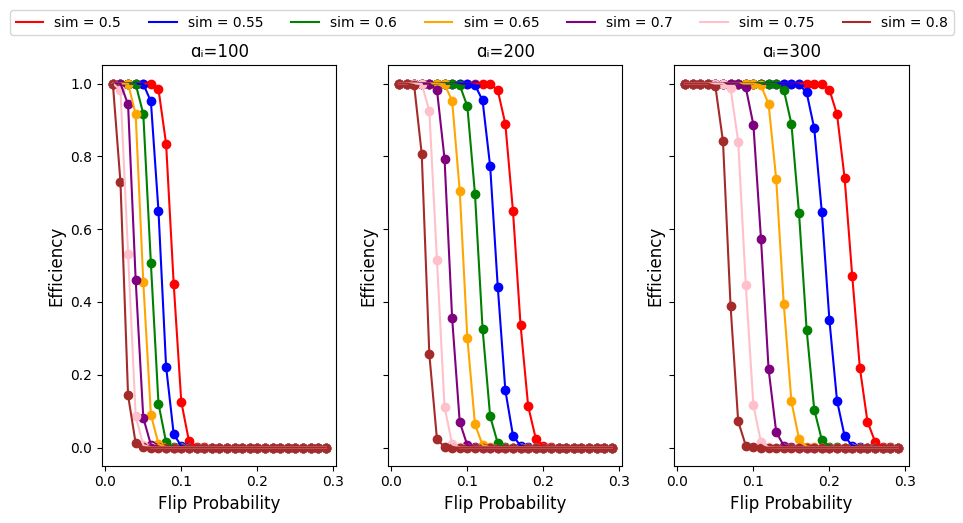

In [ ]:
num_plots = len(direct_computation)
cols = 3  #Higher settings lead to very small plots
rows = int(np.ceil(num_plots / cols))

# fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharey=True)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 5), sharey=True)
plt.title("Efficiency of the search termination criterion of CLASSIX_T for different query pop-counts. d=1000, n=10000 as a direct computation of probabilities")
axes = axes.flatten()

for i, (ax, information) in enumerate(zip(axes, direct_computation)):
    ax.plot(range_flip, information[:, 0], label="sim = 0.5", color="red")
    ax.plot(range_flip, information[:, 1], label="sim = 0.55", color="blue")
    ax.plot(range_flip, information[:, 2], label="sim = 0.6", color="green")
    ax.plot(range_flip, information[:, 3], label="sim = 0.65", color="orange")
    ax.plot(range_flip, information[:, 4], label="sim = 0.7", color="purple")
    ax.plot(range_flip, information[:, 5], label="sim = 0.75", color="pink")
    ax.plot(range_flip, information[:, 6], label="sim = 0.8", color="brown")
    ax.scatter(range_flip, information[:, 0], color="red")
    ax.scatter(range_flip, information[:, 1], color="blue")
    ax.scatter(range_flip, information[:, 2], color="green")
    ax.scatter(range_flip, information[:, 3], color="orange")
    ax.scatter(range_flip, information[:, 4], color="purple")
    ax.scatter(range_flip, information[:, 5], color="pink")
    ax.scatter(range_flip, information[:, 6], color="brown")
    ax.set_title(f"\u0251\u1d62={100*(i+1)}")
    ax.set_xlabel("Flip Probability", fontsize=12)
    ax.set_ylabel("Efficiency", fontsize=12)
    # ax.legend(fontsize='small')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
handles, labels = axes[0].get_legend_handles_labels()
# fig.suptitle("Efficiency of the search termination criterion of CLASSIX_T \n as a direct computation of probabilities", fontsize=16)
fig.legend(handles, labels, loc='upper center', ncol=7, fontsize=10, bbox_to_anchor=(0.5, 1.05), bbox_transform=fig.transFigure)
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
fig.tight_layout()
# plt.savefig("all_plot_calculation.pdf", format="pdf", dpi=600, bbox_inches='tight')
plt.show()